## SemEval 2017 Task 4: Polarity Classification

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

pd.set_option('max_colwidth', 200)

torch.manual_seed(2019)
np.random.seed(2019)
tf.random.set_random_seed(2019)
random.seed(2019)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def read_data(filename):
    df = pd.read_table(filename,
                         names=["id", "label", "text", "extra"], header=None, index_col="id",
                         quoting=csv.QUOTE_NONE)
    df.drop("extra", axis=1, inplace=True)
    
    return df


df_train = read_data("../../data/other/GOLD/Subtask_A/twitter-2016train-A.txt")
df_dev = read_data("../../data/other/GOLD/Subtask_A/twitter-2016dev-A.txt")
df_test = read_data("../../data/other/GOLD/Subtask_A/twitter-2016test-A.txt")

# Tiro una línea basura
df_test.drop(index='"', inplace=True)

X_train, labels_train = df_train["text"], df_train["label"]
X_dev, labels_dev = df_dev["text"], df_dev["label"]
X_test, labels_test = df_test["text"], df_test["label"]

In [2]:
df_train.sample(n=10)

,label,text
id,,
641603270943703040,neutral,"@search4rr @elofan1276 @ThePatriot143 By google, i mean the search engine, google maps, google email accounts. anything google you may have"
637487993171808260,positive,I just saw Jurassic World for the 7th time in theaters and yes it was worth every penny
640754950734135297,positive,"Happy 29th Birthday, Christopher Rithin (@chrisrithin)! He played one of Dudley's gang members in Harry Potter and the Order of the Phoenix."
641482474174984192,positive,This is the 1st @Madonna tour that I've had Madonna tattoos for! Wonder why it was #RebelHeart to make this happen? #RebelHeartTour
636698611867385857,positive,@MrsAshRick I used Amazon Prime to get Harper a Pete the Cat shirt :) Wish she could have it in time for the Pete the Cat parade tomorrow.
641012504081133568,negative,I am real mad that the replay of Saturday's Made In America Festival does not include Beyonce. Unhappy @TIDALHiFi subscriber!!!
641066769617154048,negative,Non stop Harry Potter in our house since Friday! Make it stop!!!
641451668639477764,positive,@TayToOoCute miss you tay! I was just looking thru my ipod &amp; I have vids of you singing back in SAT prep lol
641454770897588224,positive,Grady Harp - Top 100 Reviewer on Amazon gave my 1st #sophieandscottie book 4 stars and the 2nd book 5 stars. #chapterbooks #juvenilefiction


In [3]:
%%capture
from allennlp.commands.elmo import ElmoEmbedder
from elmoformanylangs import Embedder as ManyLangsEmbedder
import fastText
import os


fasttext_model = fastText.load_model(os.path.expanduser("../../WordVectors/wiki.en.bin"))


In [4]:
%%capture
import fastText
import os

class MyElmoAdapter:
    def __init__(self, embedder):
        self._embedder = embedder
        
    def sents2elmo(self, sents):
        #ret.append(np.array(self._elmo_embedder.sents2elmo(X_tokenized)))
        return np.array(list(self._embedder.embed_sentences(sents))).mean(axis=1)
    
# elmo_embedder = MyElmoAdapter(ElmoEmbedder(cuda_device=0))

elmo_embedder = ManyLangsEmbedder("../../models/elmo/en/")

In [5]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

y_train = label_encoder.fit_transform(labels_train.values)
y_dev = label_encoder.transform(labels_dev.values)
y_test = label_encoder.transform(labels_test.values)

y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_dev = onehot_encoder.transform(y_dev.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

label_encoder.classes_

/home/jmperez/.pyenv/versions/3.6.5/envs/hateval/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array(['negative', 'neutral', 'positive'], dtype=object)

In [27]:
df_train['label'].value_counts()

positive    3094
neutral     2043
negative     863
Name: label, dtype: int64

In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=label_encoder.classes_, y=labels_train)

class_weights = {k:v for k, v in enumerate(class_weights)}

In [29]:
from hate.nn.preprocessing import Tokenizer
from hate.nn.base_model import BaseModel
import numpy as np
from keras.layers import (
    Input, Embedding, Dense, Dropout, Bidirectional, LSTM,
    GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, CuDNNGRU, Concatenate, Softmax
)
import keras
from keras import regularizers
from elmoformanylangs import Embedder


class ElmoModel(BaseModel):
    def __init__(self, max_len, fasttext_model, elmo_embedder,
             tokenize_args={},
             recursive_class=CuDNNGRU, rnn_units=256, dropout=0.75, l1_regularization=0.00,
             pooling='max', bidirectional=False, **kwargs):


        self._max_len = max_len
        self._embedder = fasttext_model
        self._elmo_embedder = elmo_embedder
        self._elmo_dim = 1024
        # Build the graph

        inputs = []

        

        tok_args = {
            "preserve_case": False,
            "deaccent": False,
            "reduce_len": True,
            "strip_handles": True,
            "alpha_only": True,
            "stem": False
        }

        tok_args.update(tokenize_args)

        if self._elmo_embedder:
            elmo_input = Input(shape=(self._max_len, self._elmo_dim), name="Elmo")
            inputs.append(elmo_input)
        if self._embedder:
            embedding_size = fasttext_model.get_word_vector("pepe").shape[0]
            emb_input = Input(shape=(self._max_len, embedding_size), name="Fasttext")
            inputs.append(emb_input)

        if len(inputs) > 1:
            x = Concatenate()(inputs)
        else:
            x = inputs[0]

        recursive_args = {
            "return_sequences": True
        }

        if l1_regularization > .0:
            print("Using L1 regularization")
            recursive_args["kernel_regularizer"]= regularizers.l2(l1_regularization)

        rec_layer = recursive_class(
            rnn_units, **recursive_args)

        if bidirectional:
            rec_layer = Bidirectional(rec_layer)
        x = self.recursive_layer = rec_layer(x)


        if pooling == 'max':
            x = GlobalMaxPooling1D()(x)
        elif pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        else:
            raise ValueError("pooling should be 'max' or 'avg'")

        if dropout > 0:
            x = Dropout(dropout)(x)

        x = Dense(3, activation=None)(x)
        output = Softmax()(x)
        
        self.display_name = "{}{} with {} pooling consuming {}".format(
            'bi-' if bidirectional else '',
            type(recursive_class(50)).__name__,
            pooling,
            "+".join([i.name for i in inputs]),
        )
        super().__init__(
            inputs=inputs, outputs=[output],
            tokenize_args=tok_args, **kwargs
        )
        
    def preprocess_fit(self, X):
        return

    def _preprocess_tweet(self, tweet):
        tokens = self._tokenizer.tokenize(tweet)

        if len(tokens) >= self._max_len:
            tokens = tokens[:self._max_len]
        else:
            tokens = tokens + [''] * (self._max_len - len(tokens))
        return tokens

    def _get_embeddings(self, toks):
        return [self._embedder.get_word_vector(tok) for tok in toks]


    def preprocess_transform(self, X):
        X_tokenized = [self._preprocess_tweet(tweet) for tweet in X]

        ret = []

        if self._elmo_embedder:
            
            ret.append(np.array(self._elmo_embedder.sents2elmo(X_tokenized)))
        if self._embedder:
            fasttext_embeddings = np.array([
                self._get_embeddings(tweet) for tweet in X_tokenized
            ])
            ret.append(fasttext_embeddings)
        return ret


(array([3.000e+00, 3.200e+01, 3.020e+02, 5.490e+02, 1.460e+03, 2.152e+03,
        1.845e+03, 3.412e+03, 3.829e+03, 2.330e+03, 2.708e+03, 1.337e+03,
        4.930e+02, 1.100e+02, 4.600e+01, 1.700e+01, 4.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1. ,  3.7,  6.4,  9.1, 11.8, 14.5, 17.2, 19.9, 22.6, 25.3, 28. ,
        30.7, 33.4, 36.1, 38.8, 41.5, 44.2, 46.9, 49.6, 52.3, 55. ]),
 <a list of 20 Patch objects>)

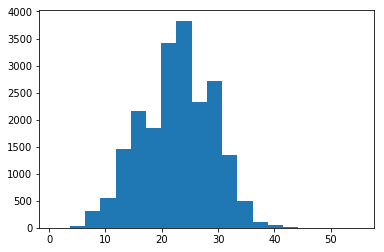

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

tokenizer = Tokenizer()

plt.hist([len(tokenizer.tokenize(tw)) for tw in X_test], bins=20)

In [31]:
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU

max_length = 33


params = {
    "recursive_class": CuDNNGRU,
    "dropout": 0.45,
    "rnn_units": 1024, 
    "dropout": 0.5,
    "pooling": 'avg',
    "tokenize_args": {
        "preserve_case": False,
        "deaccent": False,
        "reduce_len": True,
        "strip_handles": True,
        "alpha_only": False,
        "stem": False
    }
}

optimizer_args = {
    "lr": 0.0007,
    "decay": 0.01,
}

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Elmo (InputLayer)               (None, 33, 1024)     0                                            
__________________________________________________________________________________________________
Fasttext (InputLayer)           (None, 33, 300)      0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 33, 1324)     0           Elmo[0][0]                       
                                                                 Fasttext[0][0]                   
__________________________________________________________________________________________________
cu_dnngru_5 (CuDNNGRU)          (None, 33, 1024)     7219200     concatenate_3[0][0]              
__________

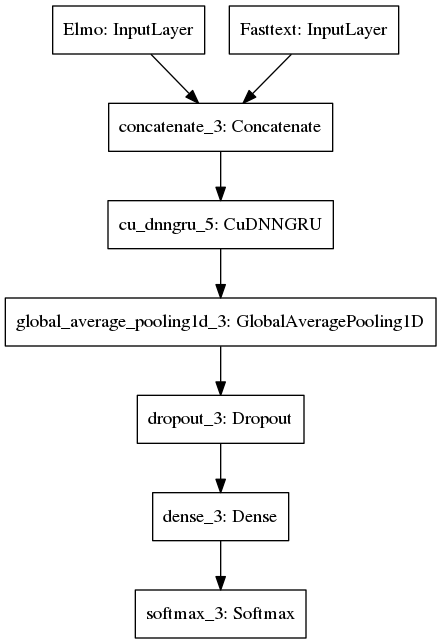

In [37]:

from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=elmo_embedder,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=10)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev),
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 6000 samples, validate on 1999 samples
Epoch 1/100
6000/6000 [==============================] - 5s 875us/step - loss: 0.5886 - acc: 0.6918 - val_loss: 0.5719 - val_acc: 0.7019

Epoch 00001: val_acc improved from -inf to 0.70185, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
6000/6000 [==============================] - 4s 606us/step - loss: 0.5389 - acc: 0.7276 - val_loss: 0.6441 - val_acc: 0.6545

Epoch 00002: val_acc did not improve from 0.70185
Epoch 3/100
6000/6000 [==============================] - 4s 595us/step - loss: 0.5182 - acc: 0.7338 - val_loss: 0.5952 - val_acc: 0.6848

Epoch 00003: val_acc did not improve from 0.70185
Epoch 4/100
6000/6000 [==============================] - 4s 591us/step - loss: 0.4953 - acc: 0.7531 - val_loss: 0.5881 - val_acc: 0.6935

Epoch 00004: val_acc did not improve from 0.70185
Epoch 5/100
6000/6000 [==============================] - 4s 593us/step - loss: 0.4705 - acc: 0.7618 - val_loss: 0.5682 - val_acc: 0.7062

Epoch 00005: 

## ELMo + fastText

In [39]:
from sklearn.metrics import accuracy_score


y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.5654808065141528

In [40]:
model_elmo_ft = model

## ELMo

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Elmo (InputLayer)            (None, 33, 1024)          0         
_________________________________________________________________
cu_dnngru_9 (CuDNNGRU)       (None, 33, 1024)          6297600   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 3075      
_________________________________________________________________
softmax_5 (Softmax)          (None, 3)                 0         
Total params: 6,300,675
Trainable params: 6,300,675
Non-trainable params: 0
_________________________________________________________________


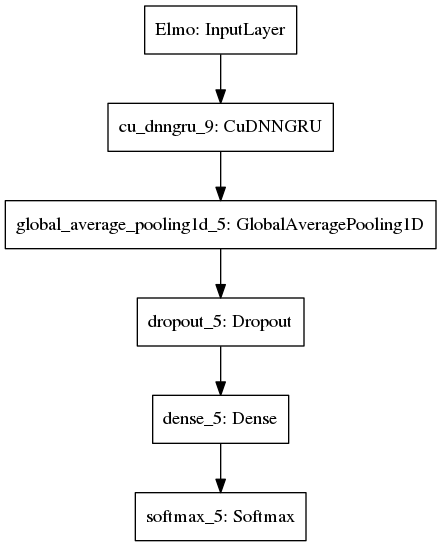

In [42]:
from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=None,
    elmo_embedder=elmo_embedder,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=10)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev),
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 6000 samples, validate on 1999 samples
Epoch 1/100
6000/6000 [==============================] - 6s 1ms/step - loss: 0.6008 - acc: 0.6829 - val_loss: 0.5544 - val_acc: 0.7057

Epoch 00001: val_acc improved from -inf to 0.70569, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
6000/6000 [==============================] - 3s 513us/step - loss: 0.5555 - acc: 0.7142 - val_loss: 0.6185 - val_acc: 0.6762

Epoch 00002: val_acc did not improve from 0.70569
Epoch 3/100
6000/6000 [==============================] - 3s 506us/step - loss: 0.5342 - acc: 0.7228 - val_loss: 0.5618 - val_acc: 0.6967

Epoch 00003: val_acc did not improve from 0.70569
Epoch 4/100
6000/6000 [==============================] - 3s 507us/step - loss: 0.5121 - acc: 0.7385 - val_loss: 0.6003 - val_acc: 0.6852

Epoch 00004: val_acc did not improve from 0.70569
Epoch 5/100
6000/6000 [==============================] - 3s 510us/step - loss: 0.5051 - acc: 0.7420 - val_loss: 0.5742 - val_acc: 0.6952

Epoch 00005: va

In [44]:
from sklearn.metrics import accuracy_score

y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.47053121364870104

In [45]:
model_elmo = model

## fastText

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Fasttext (InputLayer)        (None, 33, 300)           0         
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (None, 33, 1024)          4073472   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3075      
_________________________________________________________________
softmax_6 (Softmax)          (None, 3)                 0         
Total params: 4,076,547
Trainable params: 4,076,547
Non-trainable params: 0
_________________________________________________________________


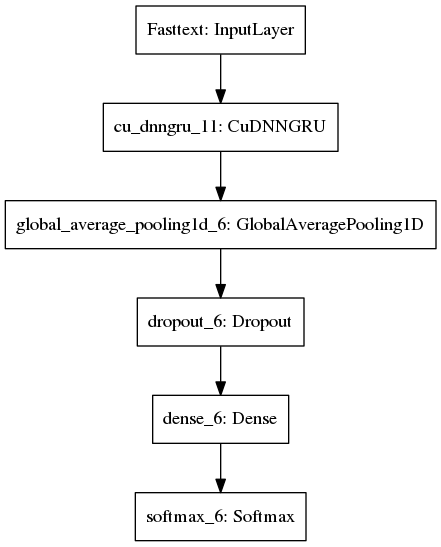

In [46]:
from keras.utils import plot_model
from IPython.display import Image


model = ElmoModel(
    max_length, fasttext_model=fasttext_model,
    elmo_embedder=None,
    **params
)

print(model.summary())




model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

plot_model(model, to_file='model.png')


Image(filename='model.png') 

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/gru_model_semeval_2016.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5)


model.fit(X_train, y_train, 
          callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev), 
          class_weight=class_weights,
          epochs=100, verbose=1,
          batch_size=64)


Train on 6000 samples, validate on 1999 samples
Epoch 1/100
6000/6000 [==============================] - 4s 698us/step - loss: 0.5947 - acc: 0.6824 - val_loss: 0.5746 - val_acc: 0.6922

Epoch 00001: val_acc improved from -inf to 0.69218, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 2/100
6000/6000 [==============================] - 2s 350us/step - loss: 0.5451 - acc: 0.7143 - val_loss: 0.5396 - val_acc: 0.7180

Epoch 00002: val_acc improved from 0.69218 to 0.71803, saving model to /tmp/gru_model_semeval_2016.h5
Epoch 3/100
6000/6000 [==============================] - 2s 337us/step - loss: 0.5260 - acc: 0.7291 - val_loss: 0.5493 - val_acc: 0.7089

Epoch 00003: val_acc did not improve from 0.71803
Epoch 4/100
6000/6000 [==============================] - 2s 337us/step - loss: 0.5113 - acc: 0.7393 - val_loss: 0.5642 - val_acc: 0.7037

Epoch 00004: val_acc did not improve from 0.71803
Epoch 5/100
6000/6000 [==============================] - 2s 347us/step - loss: 0.5017 - acc: 0.7440

In [48]:
y_pred  = model.predict(X_test) >= 0.5

accuracy_score(y_test, y_pred)

0.46713842574641334

In [49]:
model_ft = model

## SHAP

Vamos a ver si podemos hacer algo de explicabilidad...

In [54]:
import shap

path = "elmo_ft.h5"
model_elmo_ft.save(path)

model = keras.models.load_model(path)


# we use the first 100 training examples as our background dataset to integrate over
#explainer = shap.DeepExplainer(model, X_train[:100])

ValueError: Unknown layer: ElmoModel